In [1]:
import os
import cv2
import bm3d
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import ssim
from skimage.util import img_as_ubyte
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matlab.engine
eng = matlab.engine.start_matlab()

In [2]:
eng.cd(r'FastEMD', nargout=0)
eng.compile_FastEMD(nargout=0)
eng.cd(r'..', nargout=0)
eng.path_file(nargout=0)

In [3]:
import pywt

# Corrected function with pywt imported
def estimate_noise(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Convert to float for more precision in calculations
    img = np.float32(img) / 255.0
    # Perform a Discrete Wavelet Transform (DWT)
    coeffs2 = pywt.dwt2(img, 'db1')
    # Extract the detail coefficients at the finest scale
    _, (LH, HL, HH) = coeffs2
    # Calculate the Median Absolute Deviation (MAD) of the HH coefficients
    sigma = np.median(np.abs(HH - np.median(HH))) / 0.6745
    return sigma * 255  # Scale back to the original range

# Re-estimating the noise for the noisy image
estimated_noise_std = estimate_noise('Real_Test/LensBlur-1/01_01_02_01_0001.bmp') / 255.
print(estimated_noise_std)

0.008721053710772074


0.8862745098039215 0.12156862745098039


(-0.5, 15.5, 13.5, -0.5)

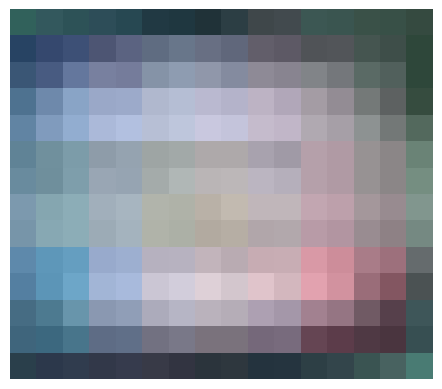

In [4]:
gt = cv2.imread('Unreal_Test/ChallengeFree/02_01_00_00_0001.bmp')
gt_img = Image.fromarray(gt, 'RGB')
gt_norm = gt.astype('float64') / 255.0
print(np.max(gt_norm), np.min(gt_norm))
plt.imshow(gt_norm)
plt.axis('off')

0.8823529411764706 0.13333333333333333


(-0.5, 15.5, 13.5, -0.5)

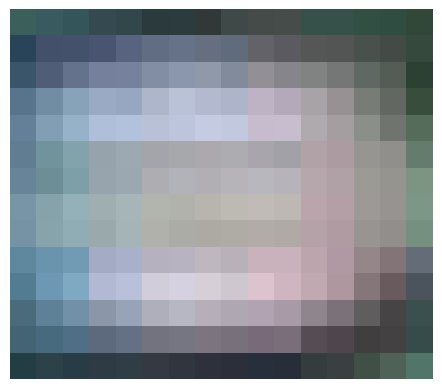

In [5]:
noisy = cv2.imread('Unreal_Test/Decolorization-1/02_01_01_01_0001.bmp')
noisy_img = Image.fromarray(noisy, 'RGB')
noisy_norm = noisy.astype('float64') / 255.0
print(np.max(noisy_norm), np.min(noisy_norm))
plt.imshow(noisy)
plt.axis('off')

In [15]:
from skimage.restoration import denoise_nl_means, estimate_sigma
def denoise_nlm(img):
    sigma_est = np.mean(estimate_sigma(img, channel_axis=2))
    print(sigma_est)
    denoise_img = denoise_nl_means(img, h= 0.01, fast_mode=True,
                               patch_size=5, patch_distance=3, channel_axis=2)
    return denoise_img

In [16]:
noise_psnr = peak_signal_noise_ratio(gt_norm, noisy_norm)
noise_ssim = structural_similarity(gt_norm, noisy_norm, data_range=noisy_norm.max() - noisy_norm.min(), channel_axis=2)
noise_cw = ssim.SSIM(gt_img).cw_ssim_value(noisy_img)
noise_unique = eng.unique_iqa(gt, noisy)
noise_msunique = eng.msunique(gt, noisy)
noise_csv = eng.csv(gt, noisy)
noise_summer = eng.SUMMER(gt, noisy)
print(noise_psnr)
print(noise_cw)
print(noise_ssim)
print(noise_unique)
print(noise_msunique)
print(noise_csv)
print(noise_summer)

32.07833050017946
0.9965282704648699
0.978230606858658
0.9217022024439631
0.9813740419572905
0.9889564933414028
4.85009289386919


0.014778964793057223
32.07714628970529
0.9964584496726413
0.9781221522602412
0.9267201739664617
0.9818494403132237
0.988879026047237
4.849504833393516


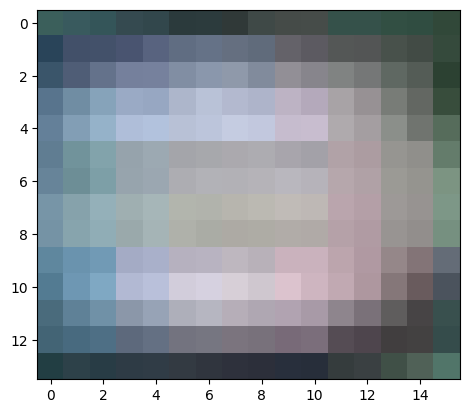

In [17]:
denoised = np.clip(denoise_nlm(noisy_norm), 0.0, 1.0)
denoised_img = Image.fromarray(img_as_ubyte(denoised), 'RGB')
noise_psnr = peak_signal_noise_ratio(gt_norm, denoised)
noise_ssim = structural_similarity(gt_norm, denoised, data_range=denoised.max() - denoised.min(), channel_axis=2)
noise_cw = ssim.SSIM(gt_img).cw_ssim_value(denoised_img)
denoised = np.ascontiguousarray(img_as_ubyte(denoised))
noise_unique = eng.unique_iqa(gt, denoised)
noise_msunique = eng.msunique(gt, denoised)
noise_csv = eng.csv(gt, denoised)
noise_summer = eng.SUMMER(gt, denoised)
print(noise_psnr)
print(noise_cw)
print(noise_ssim)
print(noise_unique)
print(noise_msunique)
print(noise_csv)
print(noise_summer) 
plt.imshow(denoised)

In [ ]:
selected_files = {'01': [], '02': [], '03': [], '04': [], '05': [], '06': [], '07': [],
                  '08': [], '09': [], '10': [], '11': [], '12': [], '13': [], '14': []}
gt_files = []

In [ ]:
for level in range(1, 6):
  folder_path = os.path.join('Unreal_Test', f'Snow-{level}')
  for file in os.listdir(folder_path):
    if file.endswith('.bmp'):
      parts = file.split('_')
      if parts[2] == '11' and parts[4] == f'00{parts[1]}.bmp':
        sign_type = parts[1]
        if sign_type in selected_files.keys():
          f = os.path.join(folder_path, file)
          selected_files[sign_type].append(f)
print(selected_files)

In [ ]:
for sign in selected_files:
  for file in os.listdir('Unreal_Test/ChallengeFree'):
    parts = file.split('_')
    if parts[1] == sign and  parts[4] == f'00{sign}.bmp':
      gt_files.append(os.path.join('Unreal_Test/ChallengeFree', file))
print(gt_files)

In [ ]:
iqa_file = {'01': [], '02': [], '03': [], '04': [], '05': [], '06': [], '07': [],
            '08': [], '09': [], '10': [], '11': [], '12': [], '13': [], '14': []}
psnr_diff = []
ssim_diff = []
cw_diff = []
u_diff = []
msu_diff = []
csv_diff = []
summer_diff = []

for i, sign in enumerate(selected_files):
  gt = cv2.imread(gt_files[i])
  gt_img = Image.fromarray(gt, 'RGB')
  gt_norm = gt.astype('float64') / 255.0
  for j, img in enumerate(selected_files[sign]):
    noisy = cv2.imread(img)
    noisy_img = Image.fromarray(noisy, 'RGB')
    noisy_norm = noisy.astype('float64') / 255.0
    
    noise_psnr = peak_signal_noise_ratio(gt_norm, noisy_norm)
    noise_ssim = structural_similarity(gt_norm, noisy_norm, data_range=noisy_norm.max() - noisy_norm.min(), 
                                       channel_axis=2)
    noise_cw = ssim.SSIM(gt_img).cw_ssim_value(noisy_img)
    noise_u = eng.unique_iqa(gt, noisy)
    noise_msu = eng.msunique(gt, noisy)
    noise_csv = eng.csv(gt, noisy)
    noise_summer = eng.SUMMER(gt, noisy)
    
    # sig = estimate_noise(img) / 255.0
    denoised = denoise_nlm(noisy_norm)
    denoised_img = Image.fromarray((denoised * 255.0).astype(np.uint8), 'RGB')
    
    denoise_psnr = peak_signal_noise_ratio(gt_norm, denoised)
    denoise_ssim = structural_similarity(gt_norm, denoised, data_range=denoised.max() - denoised.min(),
                                       channel_axis=2)
    denoise_cw = ssim.SSIM(gt_img).cw_ssim_value(denoised_img)
    denoised = np.ascontiguousarray((denoised * 255.0).astype(np.uint8))
    denoised_u = eng.unique_iqa(gt, denoised)
    denoised_msu = eng.msunique(gt, denoised)
    denoised_csv = eng.csv(gt, denoised)
    denoised_summer = eng.SUMMER(gt, denoised)
    
    iqa = {"Challenge": j+1,"Noise": (noise_psnr, noise_ssim, noise_cw, noise_u, noise_msu, noise_csv, noise_summer), 
           "Denoise": (denoise_psnr,denoise_ssim, denoise_cw, denoised_u, denoised_msu, denoised_csv, denoised_summer)}    
    iqa_file[sign].append(iqa)
    
    psnr_diff.append(denoise_psnr - noise_psnr)
    ssim_diff.append(denoise_ssim - noise_ssim)
    cw_diff.append(denoise_cw - noise_cw)
    u_diff.append(denoised_u - noise_u)
    msu_diff.append(denoised_msu - noise_msu)
    csv_diff.append(denoised_csv - noise_csv)
    summer_diff.append(denoised_summer - noise_summer)

In [ ]:
psnr_diff, ssim_diff, cw_diff, u_diff, msu_diff, csv_diff, summer_diff = np.array(psnr_diff), np.array(ssim_diff), np.array(cw_diff), np.array(u_diff), np.array(msu_diff), np.array(csv_diff), np.array(summer_diff)
min_max_mean = {"Min": [np.min(psnr_diff), np.min(ssim_diff), np.min(cw_diff), np.min(u_diff), np.min(msu_diff), np.min(csv_diff), np.min(summer_diff)], "Max": [np.max(psnr_diff), np.max(ssim_diff), np.max(cw_diff), np.max(u_diff), np.max(msu_diff), np.max(csv_diff), np.max(summer_diff)], "Mean": [np.mean(psnr_diff), np.mean(ssim_diff), np.mean(cw_diff), np.mean(u_diff), np.mean(msu_diff), np.mean(csv_diff), np.mean(summer_diff)]}
print(min_max_mean)
print(iqa_file)

In [ ]:
with open('IQA_unreal_nlm/iqa_unreal_snow_nlm.pkl', 'wb') as fp:
    pickle.dump(iqa_file, fp)
    print('saved successfully')

with open('IQA_unreal_nlm/iqa_unreal_snow_nlm_infer.pkl', 'wb') as fp:
    pickle.dump(min_max_mean, fp)   
    print('saved successfully')

In [ ]:
with open('IQA_unreal_nlm/iqa_unreal_snow_nlm.pkl', 'rb') as fp:
    iqa = pickle.load(fp)
    print(iqa)

In [ ]:
with open('IQA_unreal_nlm/iqa_unreal_snow_nlm_infer.pkl', 'rb') as fp:
  min_max_mean = pickle.load(fp)
  print(min_max_mean)